In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, GroupKFold

In [2]:
col_names = ['Engine', 'Cycles', 'OpSet_1', 'OpSet_2', 'OpSet_3']
col_names.extend(f'Sensor_{x}' for x in range (1,22))

def readFile (filename, columns):
    print(f'Reading data from {filename}...')
    return pd.read_csv(filename, sep=' ', header=None).dropna(axis=1).set_axis(columns, axis=1)

dftr = readFile('train_FD001.txt', col_names)
dfts = readFile('test_FD001.txt', col_names)
dfr = readFile('RUL_FD001.txt', ['RUL'])

dftrain = dftr.copy()
dftest = dfts.copy()

Reading data from train_FD001.txt...
Reading data from test_FD001.txt...
Reading data from RUL_FD001.txt...


In [3]:
sensors = [col for col in dftrain.columns if col not in ['Engine', 'Cycles']]
for sensor in sensors:
    print(f'{sensor}:\tVariance: {dftrain[sensor].var()} , Unique Count: {dftrain[sensor].nunique()}\t\t|\t\tVariance: {dftest[sensor].var()} , Unique Count: {dftest[sensor].nunique()}')

OpSet_1:	Variance: 4.784340124242533e-06 , Unique Count: 158		|		Variance: 4.851821565212443e-06 , Unique Count: 150
OpSet_2:	Variance: 8.588540885522267e-08 , Unique Count: 13		|		Variance: 8.645397438669485e-08 , Unique Count: 14
OpSet_3:	Variance: 0.0 , Unique Count: 1		|		Variance: 0.0 , Unique Count: 1
Sensor_1:	Variance: 0.0 , Unique Count: 1		|		Variance: 0.0 , Unique Count: 1
Sensor_2:	Variance: 0.2500532728983226 , Unique Count: 310		|		Variance: 0.1607202824753694 , Unique Count: 262
Sensor_3:	Variance: 37.59099443280496 , Unique Count: 3012		|		Variance: 25.03275001979333 , Unique Count: 2361
Sensor_4:	Variance: 81.01088641554637 , Unique Count: 4051		|		Variance: 44.733481197738996 , Unique Count: 2954
Sensor_5:	Variance: 3.15559657501012e-30 , Unique Count: 1		|		Variance: 3.1556845864144696e-30 , Unique Count: 1
Sensor_6:	Variance: 1.929279087728537e-06 , Unique Count: 2		|		Variance: 2.903904855802131e-06 , Unique Count: 2
Sensor_7:	Variance: 0.7833883045757074 , Unique 

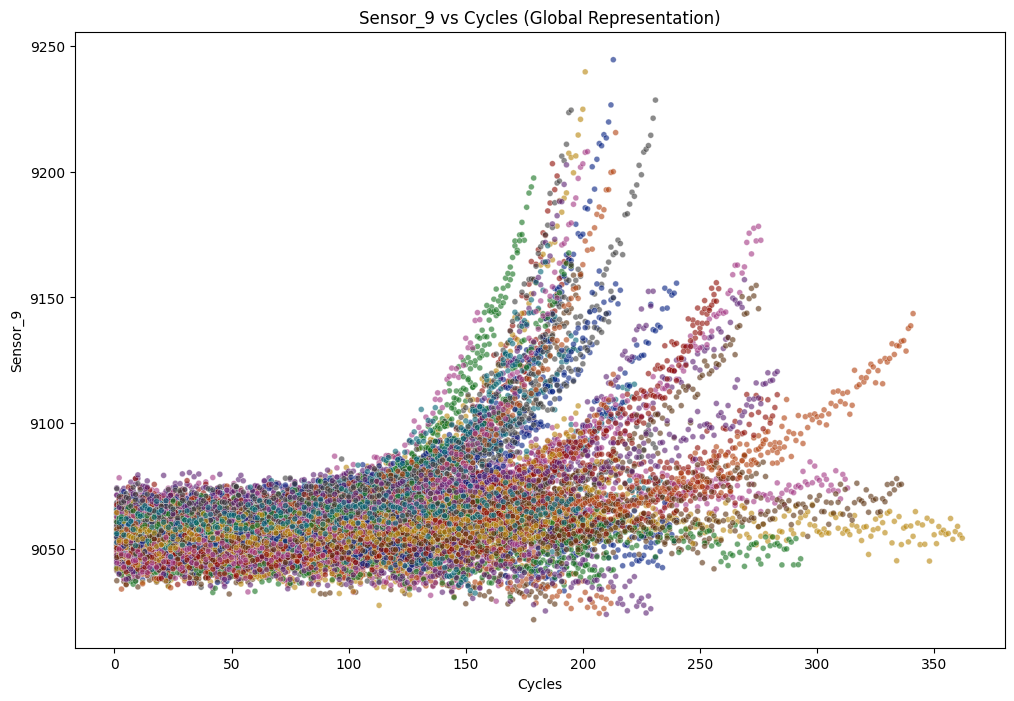

In [4]:
col = 'Sensor_9'
plt.figure(figsize=(12,8))
sns.scatterplot(data=dftrain, x='Cycles', y=col, hue='Engine', palette='dark',alpha=0.6, legend=False, size=12)
plt.title(f'{col} vs Cycles (Global Representation)')
plt.xlabel('Cycles')
plt.ylabel(col)
plt.show()

In [44]:
def plotSensors (df, title):
    fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(24, 40))
    fig.suptitle(f'Global Engine Readings for Each Sensor ({title})', fontsize=32)
    axes = axes.flatten()

    for i, sensor in enumerate(sensors):
        sns.scatterplot(data=df, x='Cycles', y=sensor, hue='Engine', palette='dark', marker='o', size=12, alpha=0.6, legend=False, ax=axes[i])
        axes[i].set_title(f'Cycles vs {sensor}', fontsize=14)  # Adjust subplot title font size
        axes[i].set_xlabel('Cycles', fontsize=12)
        axes[i].set_ylabel(sensor, fontsize=12)
        
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [45]:
#plotSensors(dftrain, title='Training Dataset')
#plotSensors(dftest, title='Test Dataset')

In [46]:
#cols = [col for col in dftr.columns if col not in ['Engine', 'Cycles']]
col = 'Sensor_6'

print(dftrain.groupby(col)['Engine'].nunique())
print('')
print(dftest.groupby(col)['Engine'].nunique())

Sensor_6
21.60     62
21.61    100
Name: Engine, dtype: int64

Sensor_6
21.60     66
21.61    100
Name: Engine, dtype: int64


In [47]:
dftrain.drop(columns=[col for col in dftrain.columns if dftrain[col].nunique() <= 2], inplace=True)
dftest.drop(columns=[col for col in dftest.columns if dftest[col].nunique() <= 2], inplace=True)

In [48]:
def plotHist (df, title):
    sensors = [col for col in df.columns if col not in ['Engine', 'Cycles']]

    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(24, 18))
    fig.suptitle(f'Global Engine Histograms for Each Sensor ({title})', fontsize=32)
    axes = axes.flatten()

    for i, sensor in enumerate(sensors):
        sns.histplot(data=df, x=sensor, bins=50, color='seagreen', alpha=0.6, ax=axes[i])
        axes[i].set_title(f'{sensor} Histogram (Global)', fontsize=14)  # Adjust subplot title font size
        axes[i].set_xlabel(sensor, fontsize=12)
        #axes[i].set_ylabel('Count', fontsize=12)
        
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

#plotHist(dftrain, 'Training Dataset')
#plotHist(dftest, 'Test Dataset')

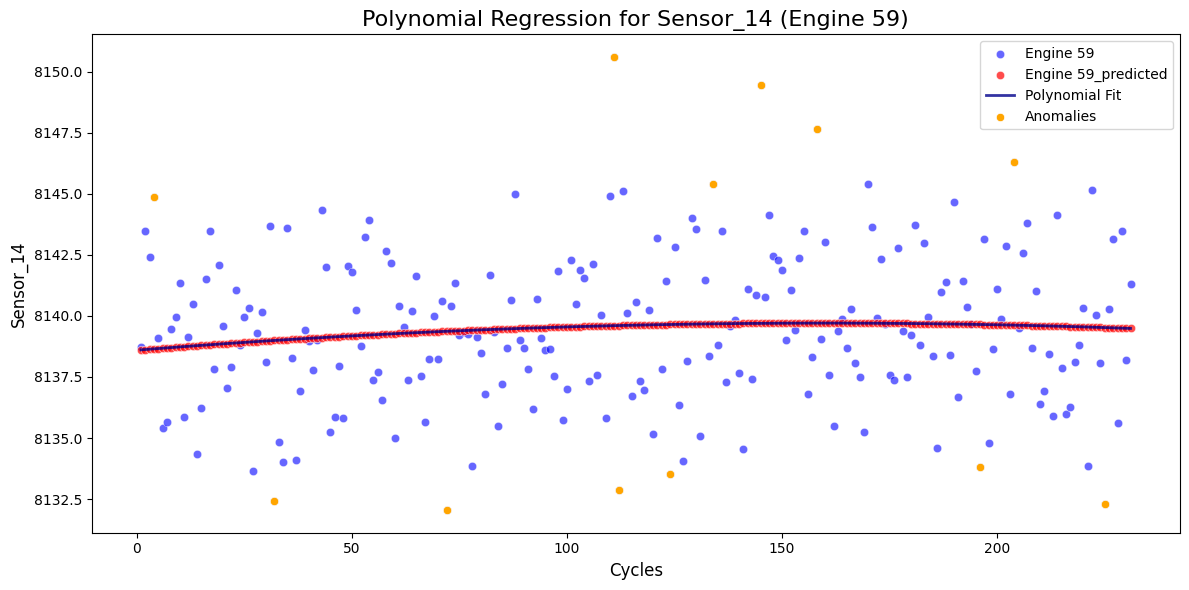

In [49]:
# Specify the engine ID to analyze
engine = 59  # Replace with the desired engine ID
sensor = 'Sensor_14'
poly_degree = 2

# Filter data for the specified engine
df_engine = dftrain.loc[dftrain['Engine'] == engine]

x = df_engine['Cycles']
y = df_engine[sensor]

# Fit polynomial regression
coefficients = np.polyfit(x, y, deg=poly_degree)
poly_func = np.poly1d(coefficients)

# Predict values
y_pred = poly_func(x)

# Calculate residuals (actual - predicted)
residuals = y - y_pred

# Define anomaly threshold (e.g., 2 standard deviations)
lower_b, upper_b = np.percentile(residuals, [2.5, 97.5])

# Identify anomalies
anomalies = df_engine[(residuals < lower_b) | (residuals > upper_b)]

# Plot results
plt.figure(figsize=(12, 6))
plt.title(f'Polynomial Regression for {sensor} (Engine {engine})', fontsize=16)
plt.xlabel('Cycles', fontsize=12)
plt.ylabel(sensor, fontsize=12)

# Scatter plot of actual data
sns.scatterplot(x=x, y=y, alpha=0.6, color='blue', label=f'Engine {engine}')
sns.scatterplot(x=x, y=y_pred, alpha=0.7, color='red', label=f'Engine {engine}_predicted')

# Polynomial regression line
x_sorted = np.sort(x)
plt.plot(x_sorted, poly_func(x_sorted), color='darkblue', linewidth=2, alpha=0.8, label='Polynomial Fit')

# Highlight anomalies
sns.scatterplot(data=anomalies, x='Cycles', y=sensor, color='orange', label='Anomalies', zorder=5)

# Add legend and show plot
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

In [50]:
# Function to replace anomalies in the input dataframe using the predicted values from its respective polynomial regression.
def anomaly_replacement_polyfunction(df):

    for engine in df['Engine'].unique():
        
        df_engine = df.loc[df['Engine'] == engine]
        sensors = [col for col in df_engine.columns if col not in ['Engine', 'Cycles', 'OpSet_2']]
        
        for sensor in sensors:
            # Independent and dependent variables
            x = df_engine['Cycles']
            y = df_engine[sensor]
            
            # Fit polynomial regression
            coefficients = np.polyfit(x, y, deg=2)
            poly_func = np.poly1d(coefficients)
            y_pred = poly_func(x)
            
            # Calculate residuals
            residuals = y - y_pred
            
            # Define lower and upper bounds using percentiles
            lower_b, upper_b = np.percentile(residuals, [5, 95])
            
            # Replace anomalies with predicted values
            anomalies_mask = (residuals < lower_b) | (residuals > upper_b)
            df.loc[df_engine.index[anomalies_mask], sensor] = y_pred[anomalies_mask]
    
    return df

In [51]:
dftrain = anomaly_replacement_polyfunction(dftrain)
dftest = anomaly_replacement_polyfunction(dftest)

C:\Users\Shahbaz\AppData\Local\Temp\ipykernel_6188\3151875341.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[392.10393408 391.88923699 391.87896523 391.87003708 391.88612184
 391.91670604 392.0355255  392.07100703 392.16555383 392.24316433
 392.54794946 392.78210744 393.16636017 393.72146296 394.05464146
 394.17174719 394.75821298 395.07613468 395.12289567 395.5090761 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df_engine.index[anomalies_mask], sensor] = y_pred[anomalies_mask]
C:\Users\Shahbaz\AppData\Local\Temp\ipykernel_6188\3151875341.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[391.7205405  391.55697239 391.44615229 391.73740014]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df_engine.index[anomalies

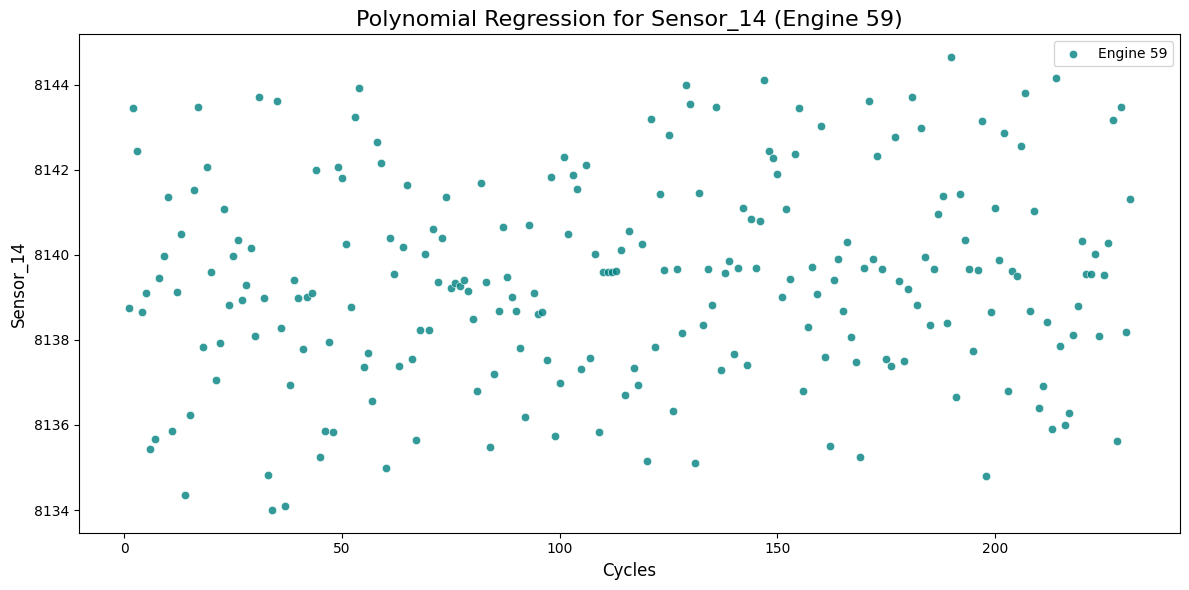

In [52]:
df_engine = dftrain.loc[dftrain['Engine'] == engine]

plt.figure(figsize=(12,6))
sns.scatterplot(data=df_engine, x='Cycles', y=sensor, color='teal', alpha=0.8, label=f'Engine {engine}')
plt.title(f'Polynomial Regression for {sensor} (Engine {engine})', fontsize=16)
plt.xlabel('Cycles', fontsize=12)
plt.ylabel(sensor, fontsize=12)

plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

In [53]:
print((dftrain['OpSet_2'].value_counts().sort_index()))

OpSet_2
-0.0006      34
-0.0005     958
-0.0004    2051
-0.0003    2104
-0.0002    2049
-0.0001    2029
 0.0000    2070
 0.0001    2097
 0.0002    2038
 0.0003    2065
 0.0004    1997
 0.0005    1068
 0.0006      71
Name: count, dtype: int64


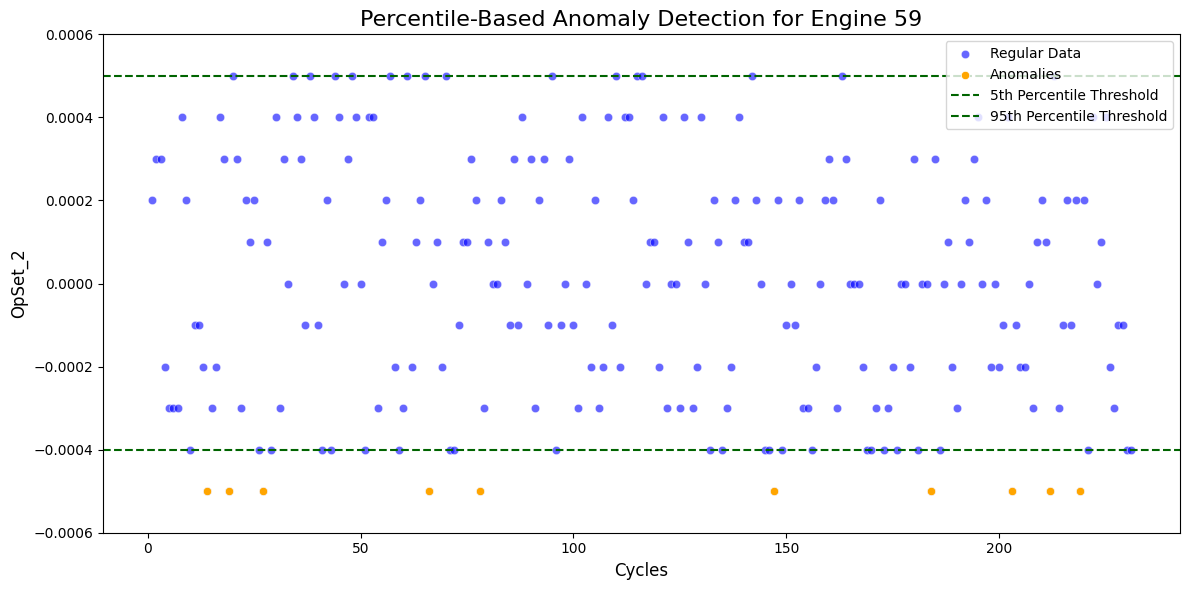

In [54]:
engine = 59
df_engine = dftrain.loc[dftrain['Engine'] == engine]

lower_bound, upper_bound = np.percentile(df_engine['OpSet_2'], [5,95])
anomalies = df_engine[(df_engine['OpSet_2'] < lower_bound) | (df_engine['OpSet_2'] > upper_bound)]

plt.figure(figsize=(12, 6))
plt.title(f'Percentile-Based Anomaly Detection for Engine {engine}', fontsize=16)
plt.xlabel('Cycles', fontsize=12)
plt.ylabel('OpSet_2', fontsize=12)
plt.ylim(-0.0006,0.0006)

sns.scatterplot(data=df_engine, x='Cycles', y='OpSet_2', color='blue', alpha=0.6, label='Regular Data')
sns.scatterplot(data=anomalies, x='Cycles', y='OpSet_2', color='orange', label='Anomalies', zorder=5)
plt.axhline(lower_bound, color='darkgreen', linestyle='--', label='5th Percentile Threshold')
plt.axhline(upper_bound, color='darkgreen', linestyle='--', label='95th Percentile Threshold')

plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

In [55]:
def anomaly_replacement_bounds(df):
    
    for engine in df['Engine'].unique():
        # Filter data for the current engine
        df_engine = df.loc[df['Engine'] == engine]
        
        # Compute the percentile boundaries
        y = df_engine['OpSet_2']
        lower_b, upper_b = np.percentile(y, [2.5, 97.5])
        
        # Identify and replace anomalies
        df.loc[df_engine.index, 'OpSet_2'] = np.where(y < lower_b, lower_b, np.where(y > upper_b, upper_b, y))
    
    return df

In [56]:
dftrain = anomaly_replacement_bounds(dftrain)
dftest = anomaly_replacement_bounds(dftest)

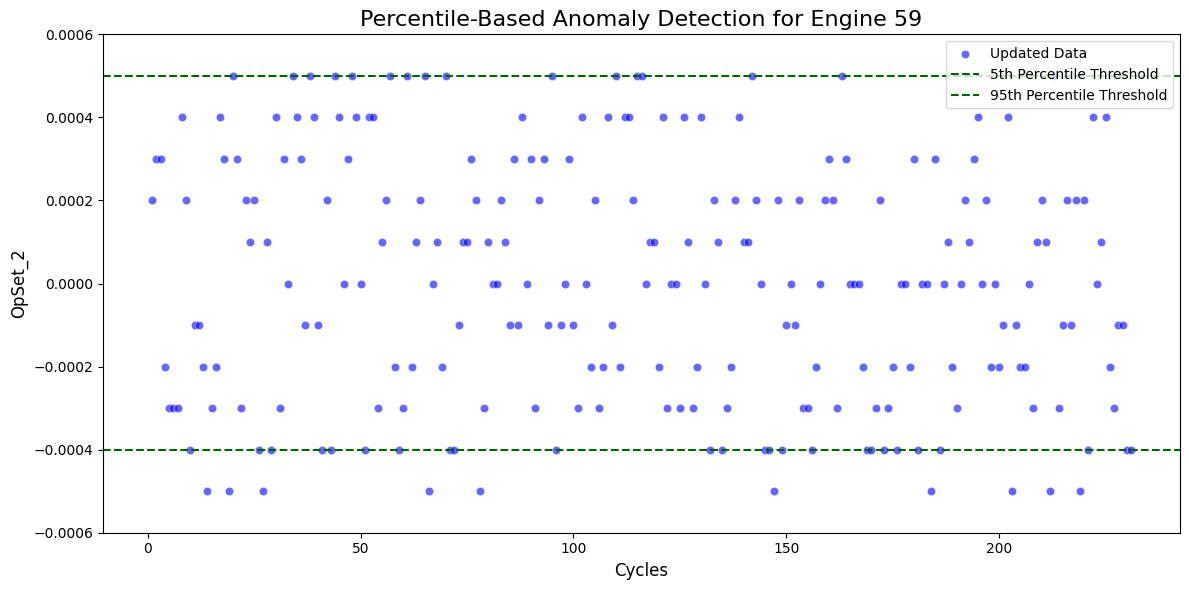

In [57]:
engine = 59
df_engine = dftrain.loc[dftrain['Engine'] == engine]

plt.figure(figsize=(12, 6))
plt.title(f'Percentile-Based Anomaly Detection for Engine {engine}', fontsize=16)
plt.xlabel('Cycles', fontsize=12)
plt.ylabel('OpSet_2', fontsize=12)
plt.ylim(-0.0006,0.0006)

sns.scatterplot(data=df_engine, x='Cycles', y='OpSet_2', color='blue', alpha=0.6, label='Updated Data')
plt.axhline(lower_bound, color='darkgreen', linestyle='--', label='5th Percentile Threshold')
plt.axhline(upper_bound, color='darkgreen', linestyle='--', label='95th Percentile Threshold')

plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

In [58]:
cycles_max = dftrain.groupby(['Engine'], as_index=False)['Cycles'].max()

for engine in cycles_max['Engine']:
    dftrain.loc[dftrain['Engine'] == engine, 'RUL'] = cycles_max.loc[cycles_max['Engine'] == engine, 'Cycles'].values[0] - dftrain.loc[dftrain['Engine'] == engine, 'Cycles']

dftrain['RUL'] = dftrain['RUL'].astype('int64')

In [59]:
def moving_avgs (df, ws=5):
    sensors = [col for col in df.columns if col.startswith('OpSet_') or col.startswith('Sensor_')]

    for engine in df['Engine'].unique():
        df_engine = df.loc[df['Engine'] == engine]
        
        for sensor in sensors:
            col_name = f'MA_{sensor}'
            df.loc[df['Engine'] == engine, col_name] = df_engine[sensor].rolling(window=ws).mean()
            df.loc[df['Engine'] == engine, col_name] = df.loc[df['Engine'] == engine, col_name].bfill()
    
    return df            

In [60]:
def consecutive_diff (df): 
    sensors = [col for col in df.columns if col.startswith('OpSet_') or col.startswith('Sensor_')]
    
    for engine in df['Engine'].unique():
        df_engine = df.loc[df['Engine'] == engine]
        
        for sensor in sensors:
            col_name = f'Diff_{sensor}'
            df.loc[df['Engine'] == engine, col_name] = df_engine[sensor].diff()  
            df[col_name] = df[col_name].fillna(0)
    
    return df

In [61]:
def scale (df, standard):
    cols = [col for col in df.columns if col not in ['Engine', 'Cycles', 'RUL']]
    
    if standard == True:
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler(feature_range=(0,1))
        
    df[cols] = scaler.fit_transform(df[cols])
    
    return df

In [62]:
def root_transform (df):
    cols = [col for col in df.columns if col not in ['Engine','Cycles','RUL'] and 'OpSet_2' not in col]
    
    sqrt = FunctionTransformer(np.sqrt)
    df[cols] = sqrt.fit_transform(df[cols])

    return df

In [63]:
# Regular Version Pipeline
pipe_regular = Pipeline(
    steps=[
        ('Moving_Averages', FunctionTransformer(moving_avgs, kw_args={'ws':5})),
        ('Consecutive_Differences', FunctionTransformer(consecutive_diff)),
        ('Scaling', FunctionTransformer(scale, kw_args={'standard':False})),
        ('OH_Encoding', FunctionTransformer(pd.get_dummies, kw_args={'columns': ['Engine'], 'drop_first': False, 'dtype': int})),
        ('Regressor', RandomForestRegressor(random_state=None, n_estimators=400, min_samples_split=12, min_samples_leaf=1, max_features='sqrt', max_depth=None))
    ]
)

In [64]:
x_train = dftrain.drop(columns=['RUL'])
y_train = dftrain['RUL']
x_test = dftest.copy()

In [65]:
'''
group_kfold = GroupKFold(n_splits=5)

parameters = {
    'Regressor__n_estimators':[100,200,300,400,500],
    'Regressor__max_depth': [None, 10, 12, 15, 20, 25, 30],
    'Regressor__min_samples_split': [2, 3, 4, 5, 10],
    'Regressor__min_samples_leaf': [1, 2, 3, 4, 5],
    'Regressor__max_features': ['sqrt']
}

gridSearch = GridSearchCV(
    pipe_regular,
    parameters,
    cv=group_kfold,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

gridSearch.fit(x_train, y_train, groups=dftrain.copy()['Engine'])
print('Best Parameters:', gridSearch.best_params_)
print('Best Score: (MSE)', -gridSearch.best_score_)
'''

"\ngroup_kfold = GroupKFold(n_splits=5)\n\nparameters = {\n    'Regressor__n_estimators':[100,200,300,400,500],\n    'Regressor__max_depth': [None, 10, 12, 15, 20, 25, 30],\n    'Regressor__min_samples_split': [2, 3, 4, 5, 10],\n    'Regressor__min_samples_leaf': [1, 2, 3, 4, 5],\n    'Regressor__max_features': ['sqrt']\n}\n\ngridSearch = GridSearchCV(\n    pipe_regular,\n    parameters,\n    cv=group_kfold,\n    scoring='neg_mean_squared_error',\n    verbose=2,\n    n_jobs=-1\n)\n\ngridSearch.fit(x_train, y_train, groups=dftrain.copy()['Engine'])\nprint('Best Parameters:', gridSearch.best_params_)\nprint('Best Score: (MSE)', -gridSearch.best_score_)\n"

In [66]:
pipe_regular.fit(x_train, y_train)
RULs_regular = pipe_regular.predict(x_test).round().astype(int)

In [67]:
dfEngine = dftest.loc[:,['Engine']]
dfEngine['RUL'] = RULs_regular

df_rul = dfEngine.groupby(['Engine'], as_index=False)[['RUL']].last()
df_rul = df_rul.sort_values(by='Engine').reset_index(drop=True)

df_rul

,Engine,RUL
0,1,163
1,2,138
2,3,40
3,4,62
4,5,81
...,...,...
95,96,125
96,97,70
97,98,56
98,99,109


In [68]:
rul_pred = df_rul['RUL'].values
rul_true = dfr['RUL'].values

mse = mean_squared_error(rul_true, rul_pred)
rmse = root_mean_squared_error(rul_true, rul_pred)
mae = mean_absolute_error(rul_true, rul_pred)
mape = mean_absolute_percentage_error(rul_true, rul_pred)
r2 = r2_score(rul_true, rul_pred)

print('--'*10 + ' RandomForest Regressor ' + '--'*10 + '\n')
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f"R^2 Score: {r2}")

-------------------- RandomForest Regressor --------------------

Mean Squared Error (MSE): 667.44
Root Mean Squared Error (RMSE): 25.834860169933183
Mean Absolute Error (MAE): 19.64
Mean Absolute Percentage Error (MAPE): 0.31608477021993503
R^2 Score: 0.613497162727284


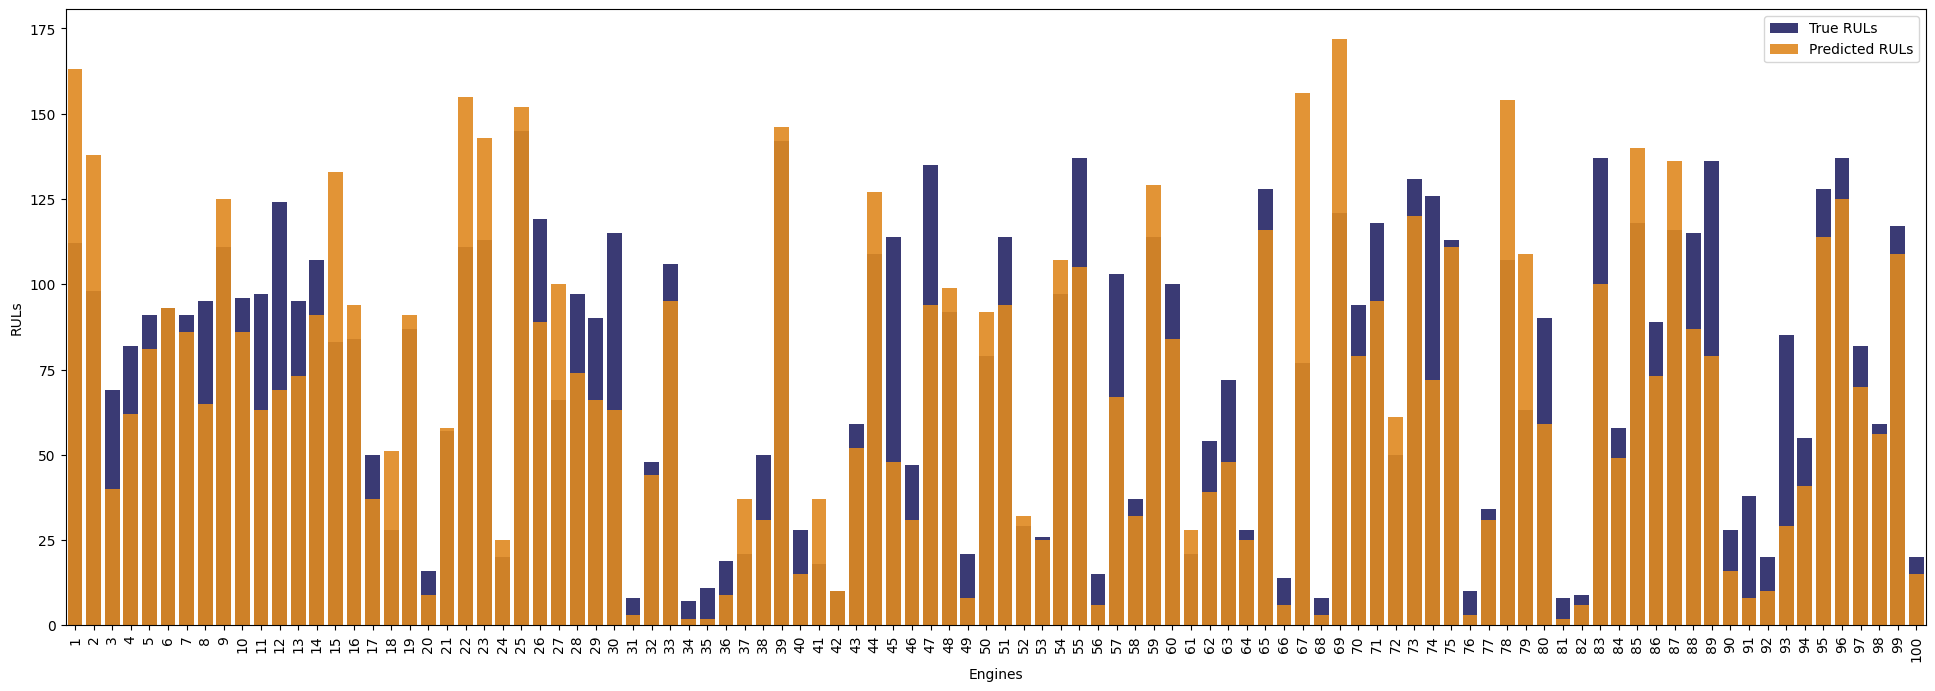

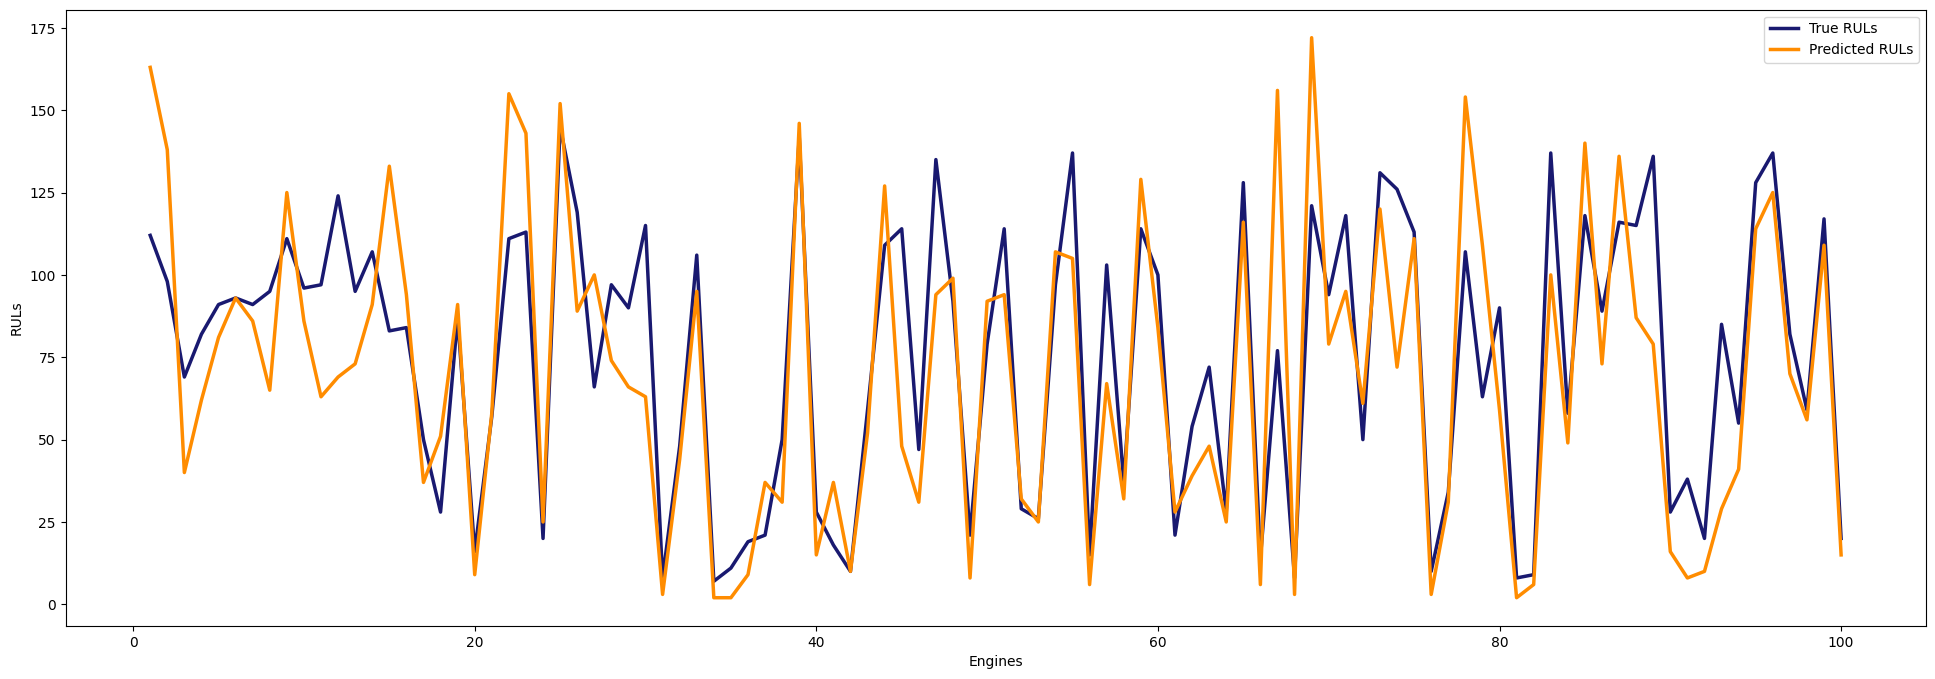

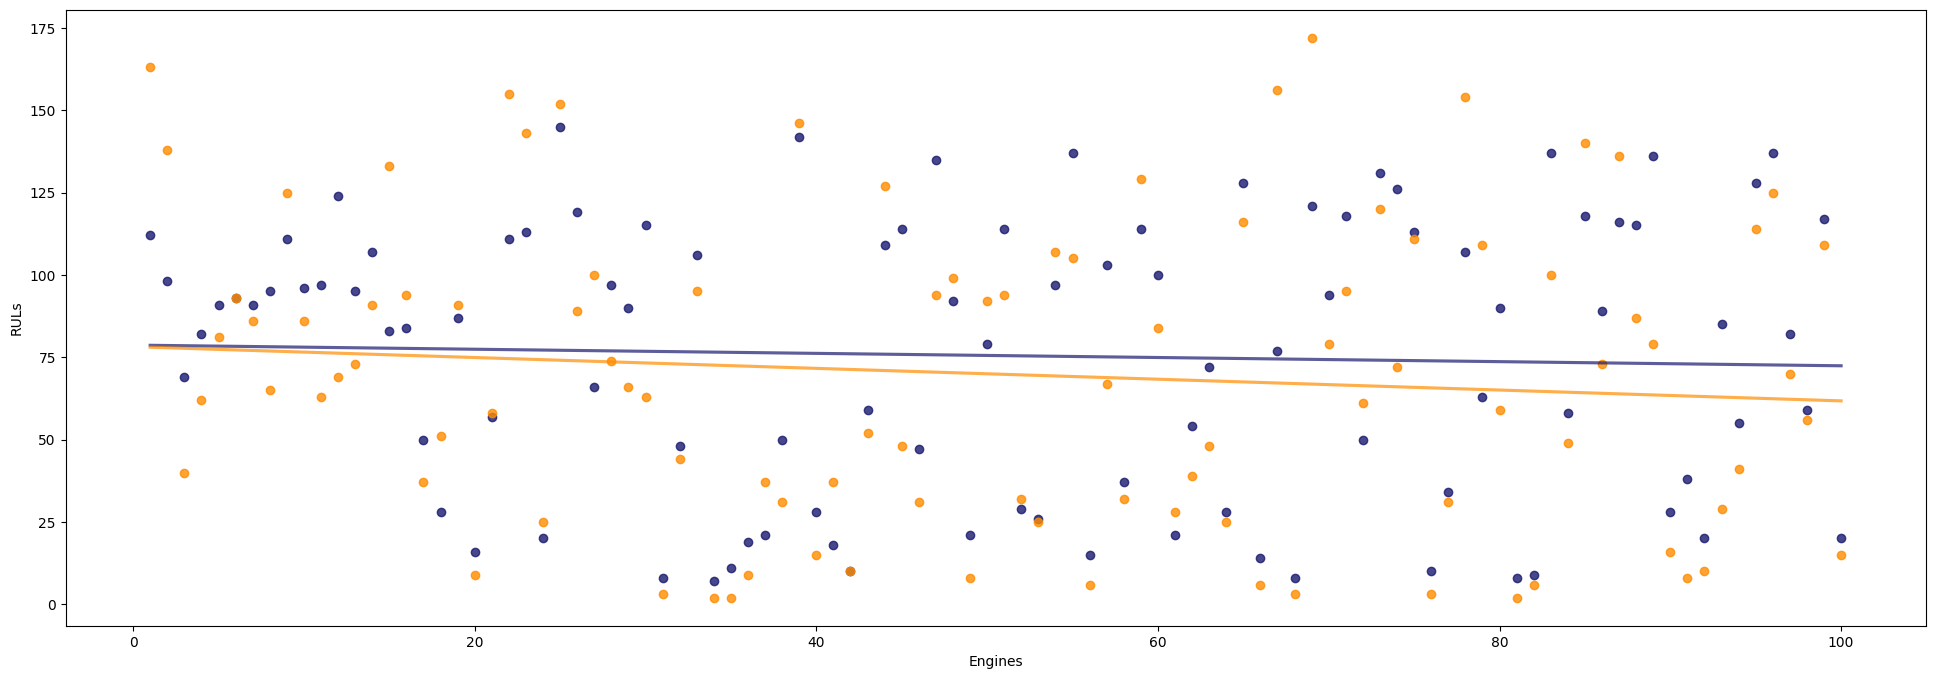

In [69]:
eng_values = df_rul['Engine'].values

plt.figure(figsize=(24,8))
sns.barplot(x=eng_values, y=rul_true, color='midnightblue', alpha=0.9, label='True RULs')  
sns.barplot(x=eng_values, y=rul_pred, color='darkorange', alpha=0.9, label='Predicted RULs')  
plt.xlabel('Engines')
plt.xticks(rotation=90)
plt.ylabel('RULs')
plt.show()

plt.figure(figsize=(24,8))
sns.lineplot(x=eng_values, y=rul_true, color='midnightblue', label='True RULs', linewidth=2.5)
sns.lineplot(x=eng_values, y=rul_pred, color='darkorange', label='Predicted RULs', linewidth=2.5)
plt.xlabel('Engines')
plt.ylabel('RULs')
plt.show()

plt.figure(figsize=(24,8))
sns.regplot(x=eng_values, y=rul_true, scatter_kws={'color': 'midnightblue', 'label': 'True RULs'}, line_kws={'color': 'midnightblue', 'alpha': 0.7}, ci=None)
sns.regplot(x=eng_values, y=rul_pred, scatter_kws={'color': 'darkorange', 'label': 'Predicted RULs'}, line_kws={'color': 'darkorange', 'alpha': 0.7}, ci=None)
plt.xlabel('Engines')
plt.ylabel('RULs')
plt.show()